# Recidivism Classification

The use of algorithms in the criminal justice system has become increasingly popular, with one such algorithm being the Compas risk assessment tool. While the exact number of features used by Compas is not publicly disclosed, it is known to consider a combination of demographic information and criminal history data to predict the risk of recidivism. However, the nature of the Compas algorithm is complex and its functioning is considered to be "black-box," making it difficult to interpret the reasoning behind its predictions.

Given the limitations and potential biases associated with the use of such black-box models, it is of interest to explore alternative approaches to predicting recidivism. This study aims to answer the question of whether recidivism can be predicted based on simple factors such as age, gender, race, and prior history of recidivism. Additionally, we aim to compare the performance of a more complex tree-based statistical model with a simpler logistic regression model.

It is hypothesized that tree-based statistical methods will yield better predictions than logistic regression, and this project aims to examine the feature importance, predictability, and model interpretability of the two approaches.

## Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from time import time
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split,cross_validate, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# set global random seed
rand = 3
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

### Load Data

We use the `Compas-scores-two-years` dataset published by ProPublica and apply the same data filter used by them to create a new dataframe compas_df. The dataset contains information on defendants charged with a crime and assessed using the COMPAS risk assessment tool. The data includes demographic information, criminal history, and the results of the COMPAS assessment, including a predicted risk score and likelihood of recidivism over a two-year period. The filter selects only the rows from the data where the number of days between the arrest and the screening is within the range of -30 to 30, the value in the is_recid column is not -1, the value in the c_charge_degree column is not "O", and the value in the score_text column is not "N/A".

In [3]:
dataURL = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
compas_df = pd.read_csv(dataURL)
compas_df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [4]:
df = compas_df.loc[
    (compas_df['days_b_screening_arrest'] <= 30) &
    (compas_df['days_b_screening_arrest'] >= -30) &
    (compas_df['is_recid'] != -1) &
    (compas_df['c_charge_degree'] != "O") &
    (compas_df['score_text'] != "N/A")
]
df.shape

(6172, 53)

Our hypothesis focuses on the predictability of recidivism based on simple factors, therefore, we only use a subset of the features available in the dataset. The selected features include 'sex', 'age', 'race', 'priors_count', and 'c_charge_degree', which will be used to predict the two-year recidivism. These features were chosen based on their simplicity and potential impact on recidivism, and represent a mix of demographic and criminal history information."

In [5]:
df = df[['sex', 'age', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]
df.shape

(6172, 6)

the dataset is composed of  6172 rows and 6 columns

### Processing Data

### Data bias 
Before analyzing the data, it is important to check for data bias. Our analysis reveals that the sample is unbalanced with regards to the race feature, where the sample data of COMPAS have extremely small representation of Asian and Native American. According to the US Census data, Asians make up about 5.23% of the nation’s overall population in 2014; in the ProPublica, however, they accounts for only 0.5% of the data.

<AxesSubplot:title={'center':'Defendants by Race Distribution'}>

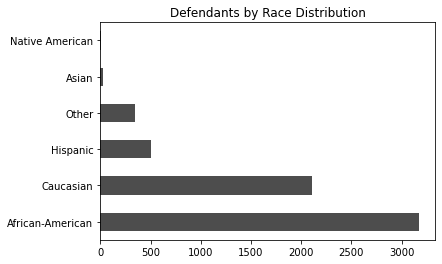

In [6]:
df['race'].value_counts().plot(
    title = "Defendants by Race Distribution",
    kind= "barh", 
    color = "#4D4D4D")

In [7]:
value_counts = df['race'].value_counts()
percentage = np.round(value_counts / len(df) * 100,3)

table = pd.concat([value_counts, percentage], axis=1)
table.columns = ['Value Counts', 'Percentage']
print("Race Distribution of Defendants")
print(table)

Race Distribution of Defendants
                  Value Counts  Percentage
African-American          3175      51.442
Caucasian                 2103      34.073
Hispanic                   509       8.247
Other                      343       5.557
Asian                       31       0.502
Native American             11       0.178


 To address this issue, we merge these two groups into a single "Other" group, making the sample data more balanced and allowing us to make more accurate predictions."

In [8]:
df.loc[df['race'].isin(['Native American', 'Asian']), 'race'] = "Other"
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                385
Name: race, dtype: int64

### Data Imbalance

In this step, we are checking the balance of the target variable, which is the rate of recidivism. According to the data, the rate of not recidivism is 45.51% and the rate of recidivism is 54.49%. This means that the data is imbalanced, with a higher rate of recidivism than not recidivism. Despite the imbalance, the difference in the rate is small, so we have decided to leave it as it is, without making any adjustments.

In [9]:
not_recid = (df['two_year_recid'].sum()/df['two_year_recid'].shape[0])*100

print("Not Recidivism Rate: %.3f%%" % not_recid)
print("Recidivism Rate: %.3f%%" % (100-not_recid))

Not Recidivism Rate: 45.512%
Recidivism Rate: 54.488%


### Categorical Data Encoding

The categorical data is converted into numerical data. The purpose of converting these variables into numerical form is to make it easier for machine learning algorithms to work with the data.

In [10]:
# Create a dictionary to store the original and encoded values
encoding_dict = {}

# # Fit and transform the data in each column
for column in ['race','sex','c_charge_degree']:
    encoder = LabelEncoder()
    # Fit and transform the data
    df[column] = encoder.fit_transform(df[column])
    
    # Create the mapping dictionary
    encoding_dict[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
# print(encoding_dict)

In [11]:
df.head()

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,1,69,3,0,0,0
1,1,34,0,0,0,1
2,1,24,0,4,0,1
5,1,44,3,0,1,0
6,1,41,1,14,0,1


## Model Implementation

### Training and Testing Data

The dataset was divided into two parts: 70% for training and 30% for testing. In order to ensure that the proportion of positive and negative samples in both the training and testing datasets was the same as in the original dataset, the stratified sampling approach was used with the target variable 'two_year_recid' as the stratification criterion. This helps to avoid any bias in the model evaluation that could result from an imbalanced distribution of the target variable in the training and testing datasets.

In [12]:
# define features, target, and stratify for splitting
features = df[['sex','age','race','priors_count','c_charge_degree']]
target = df['two_year_recid']
stratify = df['two_year_recid']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        test_size = 0.3,
        random_state = rand
)

In [84]:
X_test.head()

,sex,age,race,priors_count,c_charge_degree
2036,1,21,1,0,1
20,1,64,0,13,0
536,1,32,2,20,0
6433,0,25,0,5,0
2705,0,19,0,0,1


### Evaluation Metrics
The F1 score and AUC ROC are used as the evaluation metrics for the models due to the slight imbalance in the data class. These metrics provide a comprehensive evaluation of the model's performance in terms of precision, recall, and accuracy, allowing us to address the imbalance in the data class and accurately assess the model's ability to predict recidivism. In addition, cross validation using Stratified Kfolds with 5 splits is also employed to improve the robustness of the model evaluation results.

### Model Selections

We use Logistic Regression as the baseline model due to its simplicity and ease of interpretability. It is widely used for binary classification problems and can provide a quick and efficient solution for our problem.

For the tree-based models, we use Decision Tree and Random Forest. Random Forest is an ensemble model that builds multiple decision trees and aggregates their predictions to reduce overfitting and improve accuracy. Decision Tree, on the other hand, builds a single tree from the training data, making it easier to interpret the model. These two models are popular for their performance, scalability, and ability to handle large datasets. 

Initially, the model is implemented on the training data without any tuning or adjustments to the model's parameters. This allows us to obtain a baseline performance of the model and serves as a starting point for further optimization.

In [14]:
classifiers = {
    'Logistic Regression': {'model': Pipeline(steps = [
            ('scale', StandardScaler()),
            ('classifier', LogisticRegression(random_state = rand))])},
    'Decision Tree' : {'model': DecisionTreeClassifier(random_state = rand)},
    'Random Forest' : {'model': RandomForestClassifier(random_state = rand)},
}

In [15]:
# create a df to store the cross-validation results of each model
cv_result = pd.DataFrame(columns= ['Model', 
                                   'AVG F1', 
                                   'AVG AUC', 
                                   'AVG Precision', 
                                   'AVG Recall', 
                                   'AVG Accuracy'])

In [16]:
for model_name in classifiers.keys():
    model = classifiers[model_name]['model']
    
    # define scoring metrics
    scoring = ['f1','roc_auc','precision','recall','accuracy']
        
    # generate cross validation for with defined random state
    skf = StratifiedKFold(n_splits = 5, random_state = rand, shuffle = True)
        
    # cross validation
    scores = cross_validate(
        model, 
        X_train, 
        y_train, 
        scoring = scoring, 
        cv = skf)
    cv_result = cv_result.append({'Model': model_name, 
                                  'AVG F1': scores['test_f1'].mean(), 
                                  'AVG AUC': scores['test_roc_auc'].mean(),
                                  'AVG Precision': scores['test_precision'].mean(), 
                                   'AVG Recall': scores['test_recall'].mean(), 
                                   'AVG Accuracy': scores['test_accuracy'].mean()
                                 }, ignore_index = True
                                )

In [19]:
# print the result, sort by the AVG F1
print("Cross Validation Result")
cv_result.sort_values(by='AVG F1', ascending=False)

Cross Validation Result


,Model,AVG F1,AVG AUC,AVG Precision,AVG Recall,AVG Accuracy
0,Logistic Regression,0.607078,0.721697,0.676028,0.551145,0.675694
2,Random Forest,0.57137,0.659876,0.578241,0.564885,0.614583
1,Decision Tree,0.52679,0.608238,0.566454,0.492621,0.597685


The Logistic Regression model has demonstrated the best performance in terms of F1 score and AUC ROC. As a next step, we will fine-tune the tree-based models to see if we can improve their performance and find a model that outperforms Logistic Regression.

### Model Tuning

We utilized Random Search to find the best hyperparameters for each of the tree-based models. The hyperparameters are the parameters that cannot be learned from the training data and are used to control the learning process of the model. By fine-tuning these hyperparameters, we aimed to improve the performance of the tree-based models and find the best one for our problem.

In [20]:
# define params grid for decision tree
dt_param_dis = {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_depth': [2,5,10,20,40,None],
    'min_samples_split': [2,5,10,15],
    'max_features': ['auto','sqrt','log2',None]}

In [21]:
# define params grid for random forest
rf_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 20)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(80, 100, num = 10)],
    'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 20, num = 5)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 20, num = 2)],
    'bootstrap': [True, False]
}

In [22]:
tuning_classifiers = {
    'Decision Tree' : 
    {'model': DecisionTreeClassifier(random_state = rand), 'param_grid': dt_param_dis},
    'Random Forest' : 
    {'model': RandomForestClassifier(random_state = rand), 'param_grid': rf_param_grid}}

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
# comment out b/c running time was a bit long, the results were added to the classifiers below

for model_name in tuning_classifiers.keys():
    rs = RandomizedSearchCV(
        estimator = tuning_classifiers[model_name]['model'], 
        param_distributions = tuning_classifiers[model_name]['param_grid'], 
        n_iter = 100, 
        cv = 5, 
        scoring ='f1_micro',
        random_state = rand)
    rs.fit(X_train, y_train)
    y_pred = rs.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    cr = classification_report(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("True Negatives (TN):", tn)
    print("False Positives (FP):", fp)
    print("False Negatives (FN):", fn)
    print("True Positives (TP):", tp)
    print("Classification Report:")
    print(cr)
    print(model_name)
    print('best score = ' + str(rs.best_score_))
    print('best params = ' + str(rs.best_params_))
    print()

True Negatives (TN): 780
False Positives (FP): 228
False Negatives (FN): 344
True Positives (TP): 500
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1008
           1       0.69      0.59      0.64       844

    accuracy                           0.69      1852
   macro avg       0.69      0.68      0.68      1852
weighted avg       0.69      0.69      0.69      1852

Decision Tree
best score = 0.6668981481481482
best params = {'splitter': 'best', 'min_samples_split': 5, 'max_features': None, 'max_depth': 5, 'criterion': 'entropy'}

True Negatives (TN): 771
False Positives (FP): 237
False Negatives (FN): 333
True Positives (TP): 511
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1008
           1       0.68      0.61      0.64       844

    accuracy                           0.69      1852
   macro avg       0.69      0.69    

In [104]:
#cm_black = confusion_matrix(y_test["race"] = 0, y_pred["race"] = 0)
#cm_white = confusion_matrix(y_test["race"] = 1, y_pred["race"] = 1)
print(y_test)

2036    1
20      1
536     0
6433    1
2705    1
       ..
4925    0
956     1
3257    0
2921    0
2809    0
Name: two_year_recid, Length: 1852, dtype: int64


In [32]:
tuned_classifiers = {
    'Logistic Regression': {'model': Pipeline(steps = [
        ('scale', StandardScaler()),
        ('classifier', LogisticRegression(random_state = rand))])},
    'Decision Tree' : {'model': DecisionTreeClassifier(
        splitter = 'best', 
        min_samples_split = 5, 
        max_features = 10, 
        max_depth = 5, 
        criterion = 'gini',
        random_state = rand,)},
    'Random Forest' : {'model': RandomForestClassifier(
        n_estimators = 115,
        min_samples_split = 2,
        min_samples_leaf = 20,
        max_features = 'auto' ,
        max_depth = 100,
        bootstrap = True,
        random_state = rand)}
}

## Results

We use the Dalex package which provides a suite of tools for interpretation and explanation of complex predictive models. The use of Dalex allows us to obtain a better understanding of the relationship between our predictors and the outcome we aim to predict. 

In [24]:
# use Dalexdalex library
import dalex as dx

**Create explainer for each model**

In [74]:
# Create Explainer Object for Logistic Model
lr_model = classifiers['Logistic Regression']['model'].fit(X_train, y_train)

# create Explainer object
lr_exp = dx.Explainer(
    lr_model,
    X_test, 
    y_test,
    label = "Logistic Regression", 
    verbose = True)

Preparation of a new explainer is initiated

  -> data              : 1852 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1852 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistic Regression
  -> predict function  : <function yhat_proba_default at 0x0000018FDEECAE50> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0627, mean = 0.449, max = 0.987
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.933, mean = 0.00663, max = 0.921
  -> model_info        : package sklearn

A new explainer has been created!


In [75]:
# Create Explainer Object for Random Forest
rf_exp = dx.Explainer(
    tuned_classifiers['Random Forest']['model'],
    X_test, 
    y_test,
    label = "Random Forest", 
    verbose = True)

Preparation of a new explainer is initiated

  -> data              : 1852 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1852 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest
  -> predict function  : <function yhat_proba_default at 0x0000018FDEECAE50> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         :  'residual_function' returns an Error when executed:
This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
  -> model_info        : package sklearn

A new explainer has been created!


In [76]:
# combine into one explainer list
exp_list = [lr_exp, rf_exp]

### Model Performance

In [77]:
m_performance_list = [e.model_performance() for e in exp_list]
pd.concat([mp.result[['f1','auc']] for mp in m_performance_list], axis=0).sort_values(by='f1', ascending=False)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [29]:
m_performance_list[0].plot(m_performance_list[1], geom="roc")

NameError: name 'm_performance_list' is not defined

### Variable Importance

In [78]:
m_vi_list = [e.model_parts() for e in exp_list]

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [79]:
m_vi_list[0].plot(m_vi_list[1])

NameError: name 'm_vi_list' is not defined

**Partial Dependences**

In [80]:
m_pdp_list = [e.model_profile(type = 'partial') for e in exp_list]

Calculating ceteris paribus:   0%|                                                               | 0/5 [00:00<?, ?it/s]


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# lr_pdp = lr_exp.model_profile(type = 'partial', label="pdp")

In [ ]:
m_pdp_list[0].plot(m_pdp_list[1])

In [ ]:
# lr_pdp.plot()

In [ ]:
# lr_pdp_cat = lr_exp.model_profile(type = 'partial', variable_type='categorical',
#                             variables = ["race"], label="pdp")

In [ ]:
# lr_pdp_cat.plot()

#### Interpreting individual predictions

In [37]:
sample_1 = X_test.iloc[[3]]
sample_1.head()

,sex,age,race,priors_count,c_charge_degree
6433,0,25,0,5,0


In [38]:
reverse_encoding = { 
    'race': {0: 'African-American', 1: 'Caucasian', 2: 'Hispanic', 3: 'Other'},
    'sex': {0: 'Female', 1: 'Male'},
    'c_charge_degree':{0: 'F', 1: 'M'}}

In [39]:
sample_1_reversed = sample_1.copy()
for column in ['race','sex','c_charge_degree']:
    sample_1_reversed[column] = sample_1[column].map(reverse_encoding[column])

In [40]:
# create this to see the values
sample_1_reversed

,sex,age,race,priors_count,c_charge_degree
6433,Female,25,African-American,5,F


In [41]:
sample_1_reversed

,sex,age,race,priors_count,c_charge_degree
6433,Female,25,African-American,5,F


In [42]:
print('prediction: ', lr_exp.predict(sample_1))
print('truth: ', y_test.iloc[[3]])

prediction:  [0.59161719]
truth:  6433    1
Name: two_year_recid, dtype: int64


In [106]:
sample_1_bd_list = [e.predict_parts(sample_1, type='break_down') for e in exp_list]

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [44]:
sample_1_bd_list[0].plot(sample_1_bd_list[1])

NameError: name 'sample_1_bd_list' is not defined

In [45]:
pd.concat(bd.result for bd in sample_1_bd_list)

NameError: name 'sample_1_bd_list' is not defined

In [46]:
sample_1_shap_list = [e.predict_parts(sample_1, type='shap') for e in exp_list]

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [47]:
sample_1_shap_list[0].plot(sample_1_shap_list[1])

NameError: name 'sample_1_shap_list' is not defined

In [48]:
sample_2 = X_test.iloc[[20]]
sample_2

,sex,age,race,priors_count,c_charge_degree
2465,1,37,1,1,0


In [49]:
print('prediction: ', lr_exp.predict(sample_2))
print('truth: ', y_test.iloc[[20]])

prediction:  [0.36595884]
truth:  2465    1
Name: two_year_recid, dtype: int64


In [107]:
sample_2_shap = lr_exp.predict_parts(sample_2, type='shap')
sample_2_shap.plot()

In [136]:
df_new = X_test
df_new['y_test'] = y_test
df_new['y_pred'] = y_pred

df_new.head()

,sex,age,race,priors_count,c_charge_degree,y_test,y_pred
2036,1,21,1,0,1,1,1
20,1,64,0,13,0,1,1
536,1,32,2,20,0,0,1
6433,0,25,0,5,0,1,1
2705,0,19,0,0,1,1,0


In [147]:
df_whites = df_new.loc[df['race'] == 1]
df_blacks = df_new.loc[df['race'] == 0]

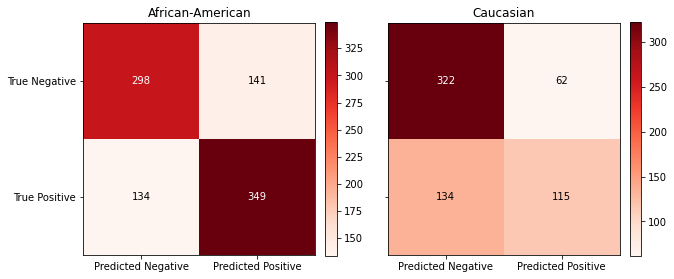

In [207]:
thresh = 150

# Calculate confusion matrices for each subset
cm1 = confusion_matrix(df_blacks['y_test'], df_blacks['y_pred'])
cm2 = confusion_matrix(df_whites['y_test'], df_whites['y_pred'])

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot first confusion matrix
im1 = ax1.imshow(cm1, cmap=plt.cm.Reds)
ax1.set_xticks(np.arange(2))
ax1.set_yticks(np.arange(2))
ax1.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
ax1.set_yticklabels(['True Negative', 'True Positive'])
plt.setp(ax1.get_xticklabels(), rotation=0, rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm1[i, j], ha="center", va="center", color="white" if cm1[i, j] > thresh else "black")
ax1.set_title("African-American")

# Plot second confusion matrix
im2 = ax2.imshow(cm2, cmap=plt.cm.Reds)
ax2.set_xticks(np.arange(2))
ax2.set_yticks(np.arange(2))
ax2.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
ax2.set_yticklabels(['', ''])
plt.setp(ax2.get_xticklabels(), rotation=0, rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        ax2.text(j, i, cm2[i, j], ha="center", va="center", color="white" if cm2[i, j] > thresh else "black")
ax2.set_title("Caucasian")

# Add colorbar
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.show()


In [173]:
# sample_2_shap.result


### Decision Tree

In [ ]:
# dt_clf = tuned_classifiers['Decision Tree']['model'].fit(X_train, y_train)

In [ ]:
# fig = plt.figure(figsize = (20,8))
# _ = plot_tree(dt_clf, filled = True)
# plt.show()

In [ ]:
# text_representation = export_text(dt_clf)
# print(text_representation)

In [ ]:
# fig.savefig("/Users/anhpham/notebooks/data_science/Group Project/DSWiSe22_Group3/decistion_tree.png")

### Random Forest

In [ ]:
# rf_exp = dx.Explainer(
#     tuned_classifiers['Random Forest']['model'],
#     X_test, 
#     y_test,
#     label = "Random Forest", 
#     verbose = True)

In [ ]:
# rf_mp = rf_exp.model_performance(model_type = 'classification')
# rf_mp.result

In [ ]:
# rf_mp.plot(geom="roc")

In [ ]:
# rf_vi = rf_exp.model_parts()

In [ ]:
# rf_vi.plot()

In [ ]:
# sample_1_bd_rf = rf_exp.predict_parts(sample_1, type='shap')

In [ ]:
# sample_1_bd_rf.plot()

In [ ]:
# rf_pdp = rf_exp.model_profile(type = 'partial', label="pdp")

In [ ]:
# rf_pdp.plot()